## 勾配消失問題について

誤差逆伝搬で誤差を下位層（入力側）へ伝搬する際に、伝搬される勾配が徐々に小さくなることで、誤差が下位層へ伝搬されずにパラメータの更新が行えず、訓練で最適解に収束しない問題

【例】シグモイド関数の場合\
下のグラフはシグモイド関数とその導関数をプロットした関数で、シグモイド関数の導関数は0.25が最大値となる。
そのため、シグモイド関数を用いた活性化層が積み重なるごとに勾配は0.25倍されていくため小さくなっていく。

Text(0.5, 1.0, 'd_sigmoid')

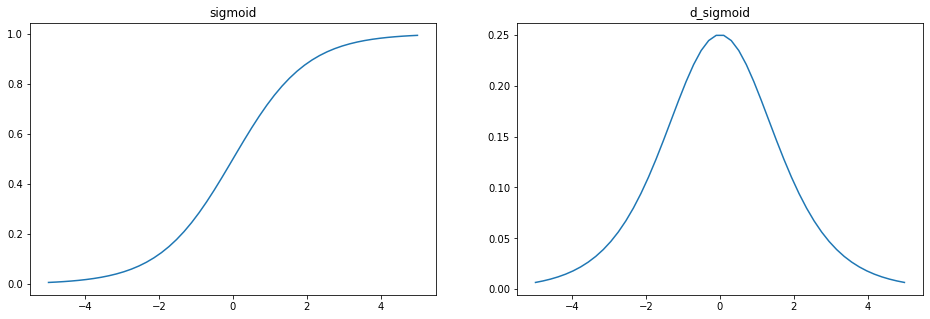

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def d_sigmoid(x):
    return sigmoid(x)*(1 - sigmoid(x))


fig, ax = plt.subplots(1,2, figsize = (16,5))
x = np.linspace(-5,5,50)
ax[0].plot(x, sigmoid(x))
ax[1].plot(x, d_sigmoid(x))

ax[0].set_title("sigmoid")
ax[1].set_title("d_sigmoid")

## 勾配消失問題の解決方法

勾配消失問題への対応方法としては次の3種類が主にある。\
①活性化関数の選択\
②重みの初期値設定\
③バッチ正則化

### ①活性化関数の選択

勾配消失への対応としてReLu関数を用いることが多い。

$$
  f(x) = \begin{cases}
    x & (x>0) \\
    0 & (x\le0)
  \end{cases}
$$

式からわかるように、導関数は$x>0$で$1$になるので、勾配がそのまま下位の層へ伝わる。
Relu関数は勾配消失問題の回避、スパース化によってよい成果が出ている。\
※スパース化：ベクトルや行列などで重要なもの以外をほとんど０とすること

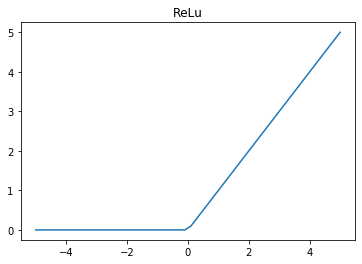

In [17]:
def relu(x):
    return np.maximum(0,x)

x = np.linspace(-5,5,50)
plt.figure()
plt.plot(x, relu(x))
plt.title("ReLu")
plt.show()

###  ②重みの初期化
初期値はすべての値を0にしたり、すべてを均一に設定することは望ましくない。
重みの初期値を0にすると、すべてのノードで誤差が同じように伝わり、複数のノードが同じように学習をしてしまい、うまく学習が進まない。\
できるだけランダムな初期値にすることが必要になる。

- #### Xavierの初期値

主にシグモイド関数、Tanh関数、（Relu関数）に用いられる。\
前層のノード数を$N$としたときに、標準偏差が$1/\sqrt{N}$となる分布を用いる

In [19]:
#実装方法
#np.random.rand(N_prev,N_next)/np.sqrt(N_prev)

- #### Heの初期値
Relu関数に用いられる初期値\
前層のノード数をNとしたときに、$\sqrt{2/N}$を標準偏差とするガウス分布を初期値に使用する

In [20]:
#実装方法
#np.random.rand(N_prev,N_next)/np.sqrt(N) * np.sqrt(2)

### ③バッチ正則化

ミニバッチ単位で入力データを活性化関数へ渡す前後で正規化する手法\
バッチ正則化を行うことで、
- 学習が速く進む
- 過学習を抑えることができる
の効果が得られる。

バッチ正則化の処理

【①】ミニバッチの平均を求める。Ntがミニバッチのデータ数
$$
 \mu = \frac{1}{N_t} \sum_{i=1}^{N_t} x_{ni}
$$

【②】データの分散を求める\
$$
 {\sigma_t}^2 = \frac{1}{N_t}  \sum_{i=1}^{N_t} (x_{ni}-\mu_t)^2
$$

【③】データを標準化する。$\theta$は0で除算することを防ぐための微小量\
$$
 \hat{x}_{ni} = \frac{x_{ni} - \mu_t}{\sqrt{{\sigma_t}^2 + \theta}}
$$

【④】スケール$\gamma$とシフト$\beta$で変換する\
$$
 y_{ni} = \gamma \hat{x}_{ni} + \beta
$$

この$y$をバッチ正則化レイヤーから出力する。\
学習のときは上記の手順でいいが、推測の段階ではバッチでデータが来ないことの方が多い。
推測のときに使用する平均、分散は学習時に移動平均、分散を求めておき、それらを用いて推測する。

## 学習率最適化手法について

ニューラルネットでは誤差関数$E(w)$を最小にするパラメータを勾配降下法で求める。\
通常の勾配降下法では、学習率$\eta$の大きい場合は学習が収束せず発散してしまう。また、学習率が小さいと収束するのに時間がかかったり、大域局所最適地に収束しにくい。\
対策として、初期の学習率を大きくし、学習とともに小さくしていく手法を使用する。
また、パラメータ毎に一律だった学習率をパラメータ毎に設定する。

学習率最適化手法
- モメンタム
- AdaGrad
- RMSProp
- Adam

###  モメンタム

【更新方法】

$$
 V_t = \mu V_{t-1} - \epsilon \nabla E \\
 W^{(t+1)} = W^{(t)} + V_t
$$
$\mu$は慣性

【説明】\
初期の$V_0$を0とすると。$V_1$は通常の勾配法と同じ形。\
次にの$V_2$を求めるときには、$\mu V_1 - \epsilon \nabla E$になる。\
前回までの移動する速度$V_{t-1}$に現在の勾配による速度が足されるイメージ

【メリット】
- 局所的最適解にはならず、大域的最適解となりやすい。
- 最適解に到達するまでの時間が早い

### AdaGrad

【更新方法】

$$
 h_0 = \theta \\
 ht = h_{t-1} + (\nabla E)^2 \\
 W^{(t+1)} = W^{(t)} - \epsilon \frac{1}{\sqrt{h_t} + \theta}  \nabla E
$$

【説明】\
hには勾配の2乗和が保持されていく。その2乗和の値$h$を使用して学習率$\epsilon$を小さくしていく

【メリット】\
こうばいが緩やかな場合は最適値に近づける

【課題】\
鞍点問題を引き起こす可能性がある

### RMSProp

【更新方法】
$$
 h_t = \alpha h_{t-1} + (1-\alpha) (\nabla E)^2 \\
 W^{(t+1)} = W{(t)} - \epsilon \frac{1}{\sqrt{h_t} + \theta} \nabla E
$$

【説明】\
AdaGradではすべての2乗和が保存されるので、更新のたびに学習率が小さくなり最終的には更新されなくなる。この点をRMSPropでは改善している。過去の勾配の情報を忘れて、新しい勾配の情報を大きく反映するようにしている。

【メリット】\
- 局所的最適解にならずに、大域的最適解となる。
- ハイパーパラメータの調整が必要な場合が少ない。

### Adam

モメンタムとRMSPropのいいところを含んだアルゴリズム。
Adamでは3つのハイパーパラメータを設定する。

#### どの方法を使用するか

すべての場合においてうまくいく方法は現状存在しない。
Adamがよく使われている場面が多いが、別の手法も試す価値はある。

## 過学習について

### 正則化

重みが大きい値をとると過学習が発生することがある。この対策として、誤差に対して重みが大きくなると誤差が大きくなるような正則化項を加算することで重みの大きさを抑制をする。一方で重みのばらつきは必要なので、どちらも達成する必要がある。

### L1, L2正則化

$$
 E(w) + \frac{1}{\lambda} || x ||_p
$$

$$
 || x ||_p = ( |x_1|^p + \dots + |x_n| ^p )^{\frac{1}{p}}
$$

$p=1$のときL1正則化、$p=2$のとき、L2正則化と呼ぶ。\
L1正則化だとほとんどの重みを0にする。

### ドロップアウト

ノード数が多いことで、複雑なモデルになりやすくなる。それにより過学習が起きやすくなる。
学習の際に、一部のノードをランダムに削除して学習を行う。

## CNN(畳み込みニューラルネットワーク）

画像認識や音声認識などで使用されるDeeplearningの手法の一つ。
NNでは全結合層だけで構成されていたが、CNNでは「畳み込み層」、「プーリング層」と全結合層で構成される。「畳み込み層」を用いることで、全結合層では失われてしまう画像の位置情報などの形状を維持したまま学習が可能になる。

### 畳み込み層

【計算の流れ】\
入力データ（画像など）とフィルター（重み）について、フィルターをずらしながら（赤⇒青）、入力データとフィルターの要素ごとの積を足し合わせたものを出力する。\
フィルターとの計算をした後、バイアス項を足す。この場合すべての出力成分に一律のバイアスを足す。

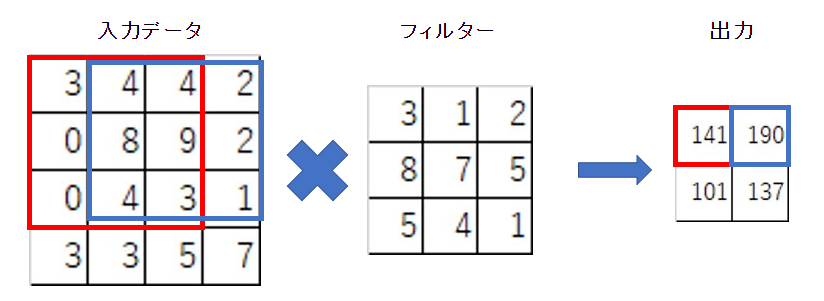

#### パディング

上記の計算でわかるように、入力データが$4 \times 4$でフィルターが$3 \times 3$のとき出力が$2 \times 2$となっており、畳み込みを行うごとに出力画像が小さくなっていく。CNNの層が深くなるとこれが問題になることがあるため、入力データの周囲を固定のデータで埋めて、出力サイズを任意の画像サイズにする操作をパディングと呼ぶ。\

下の計算の入力画像のように、周囲を0で埋めることで出力画像サイズを入力データとそろえている。

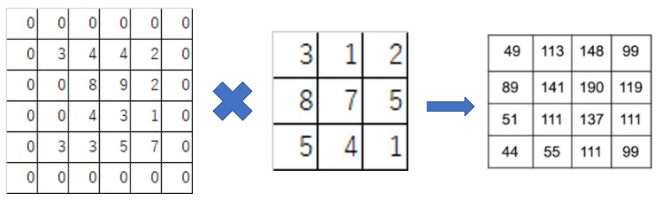

#### ストライド

フィルターのずらす量のこと。上記の例などではストライドは１で行っている。ストライド量を大きくすると当然出力画像は小さくなる。

#### チャネル

カラー画像のような場合は、(R,G,B)の値をそれぞれ入力データとして計算する。この場合、画像サイズが$128 \times 128$のとき、サイズが(128,128)でチャネル数が3となる。これは全結合層ではチャネル間の関連性が反映されないが、畳み込み層の場合はチャネル間の関係も含めて学習できる。

入力画像と出力画像のサイズの関係
OH, OWは出力画像の高さと幅、H, Wは入力画像の高さと幅、Pがパディングのサイズ、FH, FWがフィルターの高さ、幅

$$
 OH = \frac{H + 2P - FH}{S} + 1 \\
 OW = \frac{W + 2P - FW}{S} + 1
$$


### プーリング層

畳み込み層のあとに、配置される層。畳み込み層で出力された特徴Mapから特定のサイズの範囲から最大値もしくは平均値を取得して出力する。例えば$4 \times 4$のmapから$2 \times 2$の範囲でプーリングするとプーリング層の出力は$2 \times 2$になる。

## AlexNet
参考文献
1. ディープラーニングG検定公式テキスト, 日本ディープラーニング協会監修

AlexNetの構造
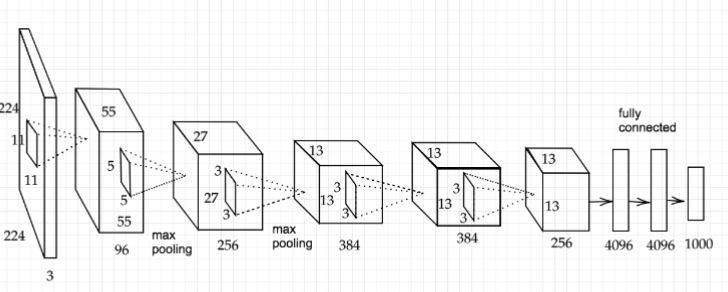

AlexNetは2012年に画像認識のコンペティションILSVRCで優勝したモデル。モデルの名前は開発者の名前からとられている。ILSVRCはImageNet Large Scale Visual Recognition Challengeの略でImageNetと呼ばれる大規模な画像のデータセットを用いたコンペ。

AlexNetの構造は5層の畳み込み層とpooling層、3層の全結合層からなるモデル。
活性化関数にRelu関数を用いていて、LRN(Local Response Normalization）やデータ拡張。GPUを2枚使用している点が特徴となっている。また、全結合層でドロップアウトを導入することで、過学習を抑制している。

2012年のコンペでは前年の2011年の誤識別率が26%だったものが、2012年のAlexNetでは16%に改善されている。一方で2017まででさらに改善されている。（2017年で2.3%）

### 確認テストまとめ

①連鎖率の原理から
$$
 z = t^2 \\
 t = x + y
$$
より$\frac{dz}{dx}$を求めよ

$$
 \frac{dz}{dx} = \frac{dz}{dt} \frac{dt}{dx} = 2t
$$

②重みの初期値を0に設定するとどのような問題が発生するか。\
⇒すべてのノードが同じように学習が進み、正しい学習が進まなくなる。

③バッチ正則化の効果を応えよ
⇒学習が速く進む、過学習が抑えられる

④$6 \times 6$の画像に$2 \times 2$のフィルターで畳み込んだ場合の出力画像のサイズは？(ストライド、パディングは1とする）\
⇒$7 \times 7$

## 実装演習（勾配消失問題）
mnistのデータを使用して、活性化関数と重みの初期値による学習の進み方を見る\
入力データ：784\
隠れ層１：40ユニット\
隠れ層２：20ユニット\
出力層：10ユニット

①重みの初期値がガウス分布の場合に、活性化関数をSigmoid関数、ReLu関数にしたときの学習の様子\
Sigmoid関数の場合、学習が進んでいないことがわかる。

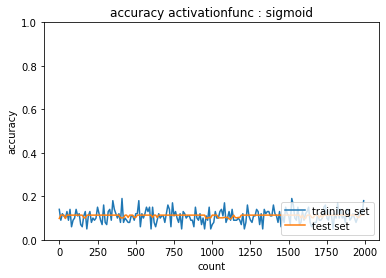

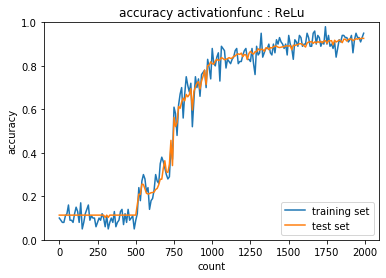

In [33]:
#データ読み込み
import numpy as np
from common import layers
from collections import OrderedDict
from common import functions
from data.mnist import load_mnist
import matplotlib.pyplot as plt

# mnistをロード
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)
train_size = len(x_train)

#モデル定義
# 重み初期値補正係数
wieght_init = 0.01
#入力層サイズ
input_layer_size = 784
#中間層サイズ
hidden_layer_1_size = 40
hidden_layer_2_size = 20

#出力層サイズ
output_layer_size = 10
# 繰り返し数
iters_num = 2000
# ミニバッチサイズ
batch_size = 100
# 学習率
learning_rate = 0.1
# 描写頻度
plot_interval=10

W_init = ["gauss", "Xavier", "He"]
activation_func = ["sigmoid", "ReLu"]


# 初期設定
def init_network(W_init):
    network = {} 
    if W_init == "gauss":
        network['W1'] = wieght_init * np.random.randn(input_layer_size, hidden_layer_1_size)
        network['W2'] = wieght_init * np.random.randn(hidden_layer_1_size, hidden_layer_2_size)
        network['W3'] = wieght_init * np.random.randn(hidden_layer_2_size, output_layer_size)
    
    elif W_init == "Xavier":
        network['W1'] = np.random.randn(input_layer_size, hidden_layer_1_size) / (np.sqrt(input_layer_size))
        network['W2'] = np.random.randn(hidden_layer_1_size, hidden_layer_2_size) / (np.sqrt(hidden_layer_1_size))
        network['W3'] = np.random.randn(hidden_layer_2_size, output_layer_size) / (np.sqrt(hidden_layer_2_size))
        
    elif W_init == "He":
        network['W1'] = np.random.randn(input_layer_size, hidden_layer_1_size) / np.sqrt(input_layer_size) * np.sqrt(2)
        network['W2'] = np.random.randn(hidden_layer_1_size, hidden_layer_2_size) / np.sqrt(hidden_layer_1_size) * np.sqrt(2)
        network['W3'] = np.random.randn(hidden_layer_2_size, output_layer_size) / np.sqrt(hidden_layer_2_size) * np.sqrt(2)


    network['b1'] = np.zeros(hidden_layer_1_size)
    network['b2'] = np.zeros(hidden_layer_2_size)
    network['b3'] = np.zeros(output_layer_size)

    return network

def forward(network, x,activation_func):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    ###########  変更箇所  ##############
    if activation_func == "sigmoid":
        hidden_f = functions.sigmoid
        
    elif activation_func == "ReLu":
        hidden_f = functions.relu    
    #################################
    
    u1 =  np.dot(x, W1) + b1
    z1 = hidden_f(u1)
    u2 =  np.dot(z1, W2) + b2
    z2 = hidden_f(u2)
    u3 =  np.dot(z2, W3) + b3
    y = functions.softmax(u3)
 
    return z1, z2, y


def backward(x, d, z1, z2, y, activation_func):
    grad = {}
    
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    ###########  変更箇所  ##############
    if activation_func == "sigmoid":
        hidden_d_f = functions.d_sigmoid
    
    elif activation_func == "ReLu":
        hidden_d_f = functions.d_relu
    
    #################################
    
    
    # 出力層でのデルタ
    delta3 = functions.d_softmax_with_loss(d, y)
    # b3の勾配
    grad['b3'] = np.sum(delta3, axis=0)
    # W3の勾配
    grad['W3'] = np.dot(z2.T, delta3)
    # 2層でのデルタ
    delta2 = np.dot(delta3, W3.T) * hidden_d_f(z2)
    # b2の勾配
    grad['b2'] = np.sum(delta2, axis=0)
    # W2の勾配
    grad['W2'] = np.dot(z1.T, delta2)
    # 1層でのデルタ
    delta1 = np.dot(delta2, W2.T) * hidden_d_f(z1)
    # b1の勾配
    grad['b1'] = np.sum(delta1, axis=0)
    # W1の勾配
    grad['W1'] = np.dot(x.T, delta1)

    return grad


def accuracy(x, d):
    z1, z2, y = forward(network, x, activation_func)
    y = np.argmax(y, axis=1)
    if d.ndim != 1 : d = np.argmax(d, axis=1)
    accuracy = np.sum(y == d) / float(x.shape[0])
    return accuracy


for activation_func in activation_func:
    W_init = "gauss"
    

    # パラメータの初期化
    network = init_network(W_init)

    accuracies_train = []
    accuracies_test = []

    for i in range(iters_num):
        # ランダムにバッチを取得    
        batch_mask = np.random.choice(train_size, batch_size)
        # ミニバッチに対応する教師訓練画像データを取得    
        x_batch = x_train[batch_mask]
        # ミニバッチに対応する訓練正解ラベルデータを取得する
        d_batch = d_train[batch_mask]



        z1, z2, y = forward(network, x_batch,activation_func)
        grad = backward(x_batch, d_batch, z1, z2, y, activation_func)

        if (i+1)%plot_interval==0:
            accr_test = accuracy(x_test, d_test)
            accuracies_test.append(accr_test)

            accr_train = accuracy(x_batch, d_batch)
            accuracies_train.append(accr_train)

            #print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
            #print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))

        # パラメータに勾配適用
        for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
            network[key]  -= learning_rate * grad[key]


    lists = range(0, iters_num, plot_interval)
    plt.plot(lists, accuracies_train, label="training set")
    plt.plot(lists, accuracies_test,  label="test set")
    plt.legend(loc="lower right")
    plt.title("accuracy" +" activationfunc : " +activation_func)
    plt.xlabel("count")
    plt.ylabel("accuracy")
    plt.ylim(0, 1.0)
    # グラフの表示
    plt.show()

②重みの初期値をXavier, Heで初期化したものを比較してみる\
Sigmoid⇒Xavierの初期値\
Relu⇒Heの初期値を使用する\

どちらも勾配消失を起こさず、学習が進んでいることがわかる

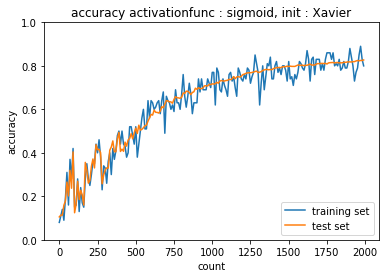

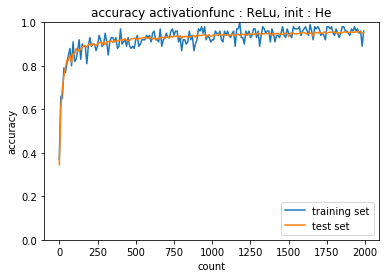

In [36]:
#データ読み込み
import numpy as np
from common import layers
from collections import OrderedDict
from common import functions
from data.mnist import load_mnist
import matplotlib.pyplot as plt

# mnistをロード
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)
train_size = len(x_train)

#モデル定義
# 重み初期値補正係数
wieght_init = 0.01
#入力層サイズ
input_layer_size = 784
#中間層サイズ
hidden_layer_1_size = 40
hidden_layer_2_size = 20

#出力層サイズ
output_layer_size = 10
# 繰り返し数
iters_num = 2000
# ミニバッチサイズ
batch_size = 100
# 学習率
learning_rate = 0.1
# 描写頻度
plot_interval=10

W_init = ["Xavier", "He"]
activation_func = ["sigmoid", "ReLu"]


# 初期設定
def init_network(W_init):
    network = {} 
    if W_init == "gauss":
        network['W1'] = wieght_init * np.random.randn(input_layer_size, hidden_layer_1_size)
        network['W2'] = wieght_init * np.random.randn(hidden_layer_1_size, hidden_layer_2_size)
        network['W3'] = wieght_init * np.random.randn(hidden_layer_2_size, output_layer_size)
    
    elif W_init == "Xavier":
        network['W1'] = np.random.randn(input_layer_size, hidden_layer_1_size) / (np.sqrt(input_layer_size))
        network['W2'] = np.random.randn(hidden_layer_1_size, hidden_layer_2_size) / (np.sqrt(hidden_layer_1_size))
        network['W3'] = np.random.randn(hidden_layer_2_size, output_layer_size) / (np.sqrt(hidden_layer_2_size))
        
    elif W_init == "He":
        network['W1'] = np.random.randn(input_layer_size, hidden_layer_1_size) / np.sqrt(input_layer_size) * np.sqrt(2)
        network['W2'] = np.random.randn(hidden_layer_1_size, hidden_layer_2_size) / np.sqrt(hidden_layer_1_size) * np.sqrt(2)
        network['W3'] = np.random.randn(hidden_layer_2_size, output_layer_size) / np.sqrt(hidden_layer_2_size) * np.sqrt(2)


    network['b1'] = np.zeros(hidden_layer_1_size)
    network['b2'] = np.zeros(hidden_layer_2_size)
    network['b3'] = np.zeros(output_layer_size)

    return network

def forward(network, x,activation_func):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    ###########  変更箇所  ##############
    if activation_func == "sigmoid":
        hidden_f = functions.sigmoid
        
    elif activation_func == "ReLu":
        hidden_f = functions.relu    
    #################################
    
    u1 =  np.dot(x, W1) + b1
    z1 = hidden_f(u1)
    u2 =  np.dot(z1, W2) + b2
    z2 = hidden_f(u2)
    u3 =  np.dot(z2, W3) + b3
    y = functions.softmax(u3)
 
    return z1, z2, y


def backward(x, d, z1, z2, y, activation_func):
    grad = {}
    
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    ###########  変更箇所  ##############
    if activation_func == "sigmoid":
        hidden_d_f = functions.d_sigmoid
    
    elif activation_func == "ReLu":
        hidden_d_f = functions.d_relu
    
    #################################
    
    
    # 出力層でのデルタ
    delta3 = functions.d_softmax_with_loss(d, y)
    # b3の勾配
    grad['b3'] = np.sum(delta3, axis=0)
    # W3の勾配
    grad['W3'] = np.dot(z2.T, delta3)
    # 2層でのデルタ
    delta2 = np.dot(delta3, W3.T) * hidden_d_f(z2)
    # b2の勾配
    grad['b2'] = np.sum(delta2, axis=0)
    # W2の勾配
    grad['W2'] = np.dot(z1.T, delta2)
    # 1層でのデルタ
    delta1 = np.dot(delta2, W2.T) * hidden_d_f(z1)
    # b1の勾配
    grad['b1'] = np.sum(delta1, axis=0)
    # W1の勾配
    grad['W1'] = np.dot(x.T, delta1)

    return grad


def accuracy(x, d):
    z1, z2, y = forward(network, x, activation_func)
    y = np.argmax(y, axis=1)
    if d.ndim != 1 : d = np.argmax(d, axis=1)
    accuracy = np.sum(y == d) / float(x.shape[0])
    return accuracy


for W_init, activation_func in zip(W_init, activation_func):
       

    # パラメータの初期化
    network = init_network(W_init)

    accuracies_train = []
    accuracies_test = []

    for i in range(iters_num):
        # ランダムにバッチを取得    
        batch_mask = np.random.choice(train_size, batch_size)
        # ミニバッチに対応する教師訓練画像データを取得    
        x_batch = x_train[batch_mask]
        # ミニバッチに対応する訓練正解ラベルデータを取得する
        d_batch = d_train[batch_mask]



        z1, z2, y = forward(network, x_batch,activation_func)
        grad = backward(x_batch, d_batch, z1, z2, y, activation_func)

        if (i+1)%plot_interval==0:
            accr_test = accuracy(x_test, d_test)
            accuracies_test.append(accr_test)

            accr_train = accuracy(x_batch, d_batch)
            accuracies_train.append(accr_train)

            #print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
            #print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))

        # パラメータに勾配適用
        for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
            network[key]  -= learning_rate * grad[key]


    lists = range(0, iters_num, plot_interval)
    plt.plot(lists, accuracies_train, label="training set")
    plt.plot(lists, accuracies_test,  label="test set")
    plt.legend(loc="lower right")
    plt.title("accuracy" +" activationfunc : " +activation_func + ", init : " + W_init)
    plt.xlabel("count")
    plt.ylabel("accuracy")
    plt.ylim(0, 1.0)
    # グラフの表示
    plt.show()

### BacthNormalizaion

コード実装理解

In [43]:
class BatchNoramalization:
    
    
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma #正規化の係数
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None
        
        self.running_mean = running_mean
        self.running_var = running_var
        
        #backwardで使用する中間データ
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None
        
    def forward(self, x, train_flg=True):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
            
        if train_flg:
            mu = x.mean(axis=0) # 平均
            xc = x - mu # xをセンタリング
            var = np.mean(xc**2, axis=0) # 分散
            std = np.sqrt(var + 10e-7) # スケーリング
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            
            #前回のバッチまでの平均と今回の平均の加重平均を計算する。前回の割合がmomentumであらわされる　。
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu # 平均の加重平均
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var #分散値の加重平均
            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
        
        out = self.gamma * xn + self.beta 
        
        return out
    
    
    def backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size

        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx      

## 実装演習（学習率最適化手法）

各最適化手法で比較するために、各手法を関数で定義

In [88]:
def Momentum(iters_num,accuracies_train, accuracies_test,train_loss_list, network,x_train,d_train, x_test, d_test):
    
    
    iters_num = 1000
    train_size = x_train.shape[0]
    batch_size = 100
    learning_rate = 0.3
    # 慣性
    momentum = 0.9
    
    for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        d_batch = d_train[batch_mask]

        # 勾配
        grad = network.gradient(x_batch, d_batch)
        if i == 0:
            v = {}
        for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
            if i == 0:
                v[key] = np.zeros_like(network.params[key])
            v[key] = momentum * v[key] - learning_rate * grad[key]
            network.params[key] += v[key]

            loss = network.loss(x_batch, d_batch)
            train_loss_list.append(loss)

        if (i + 1) % plot_interval == 0:
            accr_test = network.accuracy(x_test, d_test)
            accuracies_test.append(accr_test)        
            accr_train = network.accuracy(x_batch, d_batch)
            accuracies_train.append(accr_train)

    return accuracies_train, accuracies_test, train_loss_list

In [89]:
def AdaGrad(iters_num,accuracies_train, accuracies_test,train_loss_list, network,x_train,d_train, x_test, d_test):
    
    iters_num = 1000
    train_size = x_train.shape[0]
    batch_size = 100
    learning_rate = 0.1
    for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        d_batch = d_train[batch_mask]

        # 勾配
        grad = network.gradient(x_batch, d_batch)
        if i == 0:
            h = {}
        for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):

            # 変更しよう  
            # ===========================================
            if i == 0:
                h[key] = np.zeros_like(network.params[key])        
            h[key] = momentum * h[key] - learning_rate * grad[key]
            network.params[key] += h[key]

            # ===========================================

            loss = network.loss(x_batch, d_batch)
            train_loss_list.append(loss)

        if (i + 1) % plot_interval == 0:
            accr_test = network.accuracy(x_test, d_test)
            accuracies_test.append(accr_test)        
            accr_train = network.accuracy(x_batch, d_batch)
            accuracies_train.append(accr_train)
            
    return accuracies_train, accuracies_test, train_loss_list

In [98]:
def RMSprop(iters_num,accuracies_train, accuracies_test,train_loss_list, network,x_train,d_train, x_test, d_test):
    
    iters_num = 1000
    train_size = x_train.shape[0]
    batch_size = 100
    learning_rate = 0.01
    decay_rate = 0.99
    
    for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        d_batch = d_train[batch_mask]

        # 勾配
        grad = network.gradient(x_batch, d_batch)
        if i == 0:
            h = {}
        for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
            if i == 0:
                h[key] = np.zeros_like(network.params[key])
            h[key] *= decay_rate
            h[key] += (1 - decay_rate) * np.square(grad[key])
            network.params[key] -= learning_rate * grad[key] / (np.sqrt(h[key]) + 1e-7)

            loss = network.loss(x_batch, d_batch)
            train_loss_list.append(loss)                

        if (i + 1) % plot_interval == 0:
            accr_test = network.accuracy(x_test, d_test)
            accuracies_test.append(accr_test)        
            accr_train = network.accuracy(x_batch, d_batch)
            accuracies_train.append(accr_train)
        
    return accuracies_train, accuracies_test, train_loss_list
                                    

In [99]:
def Adam(iters_num,accuracies_train, accuracies_test,train_loss_list, network,x_train,d_train, x_test, d_test):
    
    iters_num = 1000
    train_size = x_train.shape[0]
    batch_size = 100
    learning_rate = 0.01
    beta1 = 0.9
    beta2 = 0.999
    
    for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        d_batch = d_train[batch_mask]

        # 勾配
        grad = network.gradient(x_batch, d_batch)
        if i == 0:
            m = {}
            v = {}
        learning_rate_t  = learning_rate * np.sqrt(1.0 - beta2 ** (i + 1)) / (1.0 - beta1 ** (i + 1))    
        for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
            if i == 0:
                m[key] = np.zeros_like(network.params[key])
                v[key] = np.zeros_like(network.params[key])

            m[key] += (1 - beta1) * (grad[key] - m[key])
            v[key] += (1 - beta2) * (grad[key] ** 2 - v[key])            
            network.params[key] -= learning_rate_t * m[key] / (np.sqrt(v[key]) + 1e-7)                


        if (i + 1) % plot_interval == 0:
            accr_test = network.accuracy(x_test, d_test)
            accuracies_test.append(accr_test)        
            accr_train = network.accuracy(x_batch, d_batch)
            accuracies_train.append(accr_train)
            loss = network.loss(x_batch, d_batch)
            train_loss_list.append(loss)
        
    return accuracies_train, accuracies_test, train_loss_list

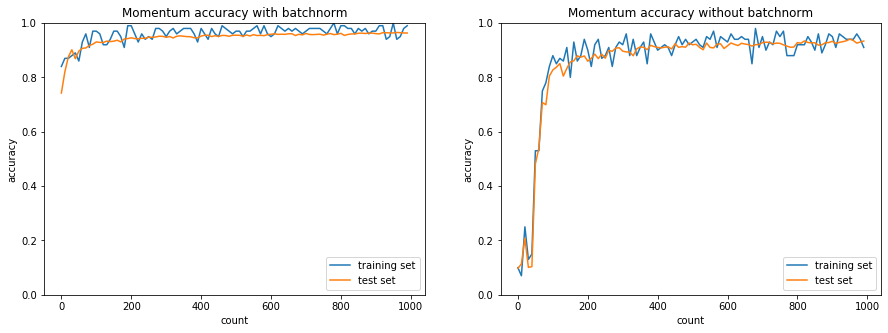

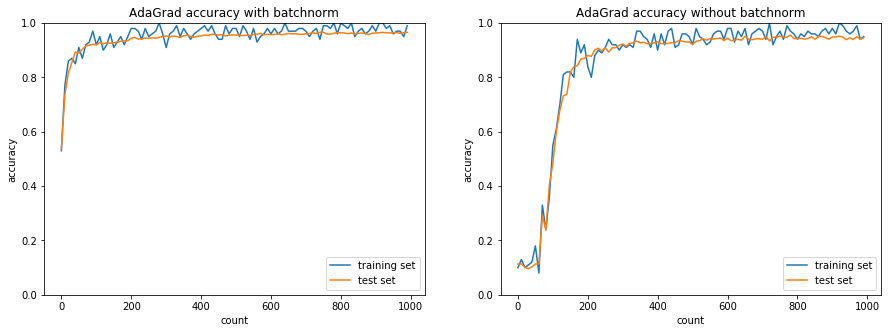

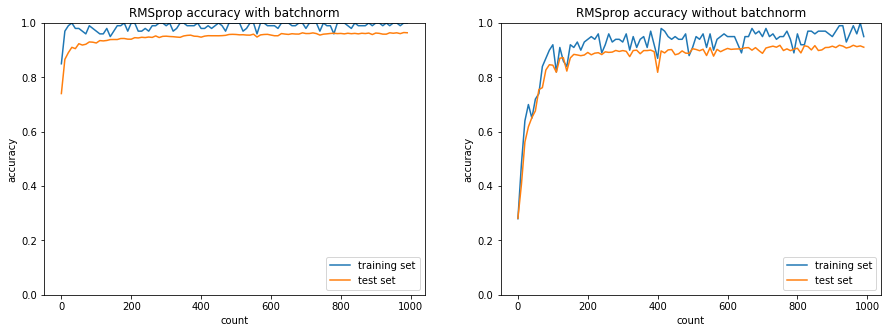

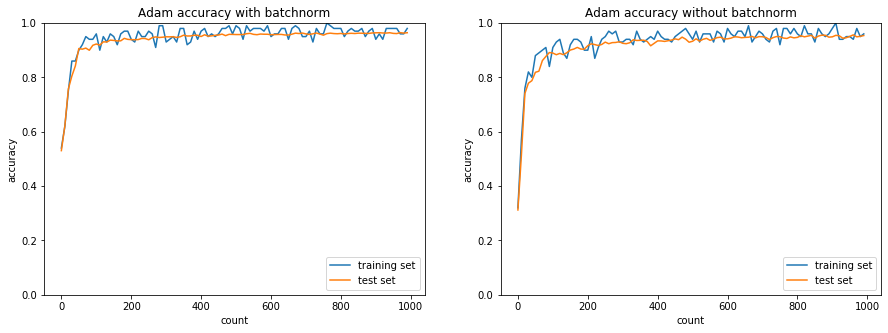

In [100]:
import numpy as np
from collections import OrderedDict
from common import layers
from data.mnist import load_mnist
import matplotlib.pyplot as plt
from multi_layer_net import MultiLayerNet

# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)


optimizer = ["Momentum", "AdaGrad", "RMSprop", "Adam"]

for opt in optimizer:
    
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    
    for i, flag in enumerate([True, False]):
        use_batchnorm = flag
    # batch_normalizationの設定 =======================
    #use_batchnorm = True
    #use_batchnorm = False
    # ====================================================

        network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='relu', weight_init_std=0.01,
                               use_batchnorm=use_batchnorm)

        iters_num = 1000
        

        train_loss_list = []
        accuracies_train = []
        accuracies_test = []

        plot_interval=10
        
        if opt == "Momentum":
            accuracies_train,accuracies_test,train_loss_list = Momentum(iters_num,accuracies_train, accuracies_test,train_loss_list, network,x_train,d_train, x_test, d_test)

        elif opt == "AdaGrad":
            accuracies_train,accuracies_test,train_loss_list = AdaGrad(iters_num,accuracies_train, accuracies_test,train_loss_list, network,x_train,d_train, x_test, d_test)

        elif opt == "RMSprop":
            accuracies_train,accuracies_test,train_loss_list = RMSprop(iters_num,accuracies_train, accuracies_test,train_loss_list, network,x_train,d_train, x_test, d_test)

        elif opt == "Adam":
            accuracies_train,accuracies_test,train_loss_list = Adam(iters_num,accuracies_train, accuracies_test,train_loss_list, network,x_train,d_train, x_test, d_test)


        lists = range(0, iters_num, plot_interval)
        
        
        
        ax[i].plot(lists, accuracies_train, label="training set")
        ax[i].plot(lists, accuracies_test,  label="test set")
        ax[i].legend(loc="lower right")
        if flag:
            ax[i].set_title(opt + " accuracy with batchnorm")

        else:
            ax[i].set_title(opt + " accuracy without batchnorm")
        ax[i].set_xlabel("count")
        ax[i].set_ylabel("accuracy")
        ax[i].set_ylim(0, 1.0)
        # グラフの表示
    plt.show()

RMSPropが過学習気味か。どの最適化手法でもBatchNormalizationを適用したほうが学習速度が速いことがわかる。

## 実装演習（過学習）
過学習を起こしやすいように学習データを削減する。
L1, L2正則と正則化しない場合を比較する。\

L2正則化で少し、過学習を抑える方向に進んでいることがわかる。
L1正則かも抑える方向に進んでいるものの、正解率がガタついている。

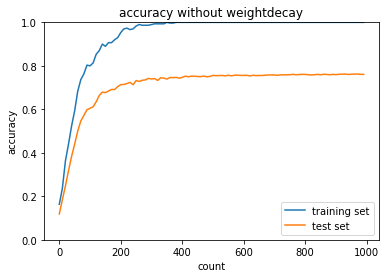

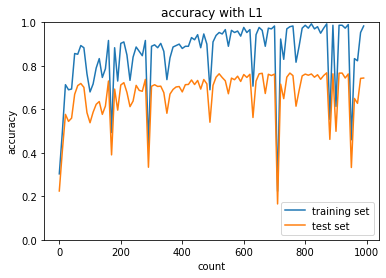

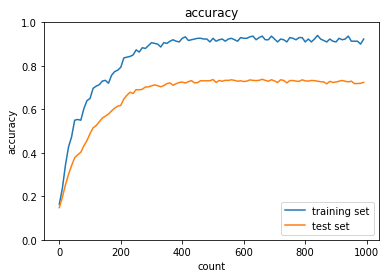

In [106]:
import numpy as np
from collections import OrderedDict
from common import layers
from data.mnist import load_mnist
import matplotlib.pyplot as plt
from multi_layer_net import MultiLayerNet
from common import optimizer


(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True)

#print("データ読み込み完了")

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
d_train = d_train[:300]

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)
optimizer = optimizer.SGD(learning_rate=0.01)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10


for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
        
    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)

        #print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        #print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy without weightdecay")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()


network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)


iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate=0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10
hidden_layer_num = network.hidden_layer_num

# 正則化強度設定 ======================================
weight_decay_lambda = 0.005
# =================================================

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    weight_decay = 0
    
    for idx in range(1, hidden_layer_num+1):
        grad['W' + str(idx)] = network.layers['Affine' + str(idx)].dW + weight_decay_lambda * np.sign(network.params['W' + str(idx)])
        grad['b' + str(idx)] = network.layers['Affine' + str(idx)].db
        network.params['W' + str(idx)] -= learning_rate * grad['W' + str(idx)]
        network.params['b' + str(idx)] -= learning_rate * grad['b' + str(idx)]        
        weight_decay += weight_decay_lambda * np.sum(np.abs(network.params['W' + str(idx)]))

    loss = network.loss(x_batch, d_batch) + weight_decay
    train_loss_list.append(loss)        
        
    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        #print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        #print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               
                
lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy with L1")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()


network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)


iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate=0.01

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10
hidden_layer_num = network.hidden_layer_num

# 正則化強度設定 ======================================
weight_decay_lambda = 0.1
# =================================================

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    weight_decay = 0
    
    for idx in range(1, hidden_layer_num+1):
        grad['W' + str(idx)] = network.layers['Affine' + str(idx)].dW + weight_decay_lambda * network.params['W' + str(idx)]
        grad['b' + str(idx)] = network.layers['Affine' + str(idx)].db
        network.params['W' + str(idx)] -= learning_rate * grad['W' + str(idx)]
        network.params['b' + str(idx)] -= learning_rate * grad['b' + str(idx)]        
        weight_decay += 0.5 * weight_decay_lambda * np.sqrt(np.sum(network.params['W' + str(idx)] ** 2))

    loss = network.loss(x_batch, d_batch) + weight_decay
    train_loss_list.append(loss)        
        
    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        #print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        #print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               


lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

## Dropout

### 実装

In [108]:
class Dropout:
    def __init__(self, dropout_ratio=0.5): #学習のときにDropoutする割合を決める。
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

## 実行
今回の実行ではエポック数を1500に設定しているが、学習回数が進むにつれて過学習気味になっていく。
Dropoutの比率を変えるだけでは、過学習を抑えきるのは難しそう。正則化と組み合わせて使う必要あり。

データ読み込み完了


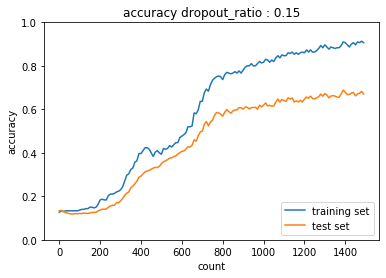

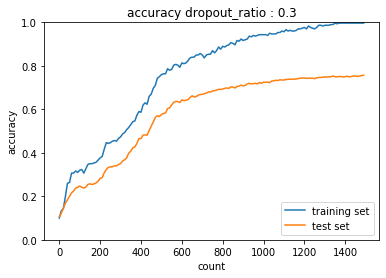

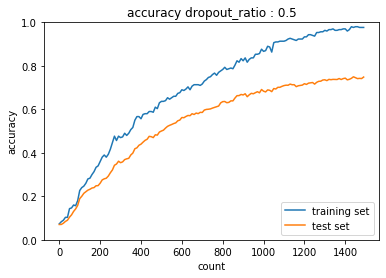

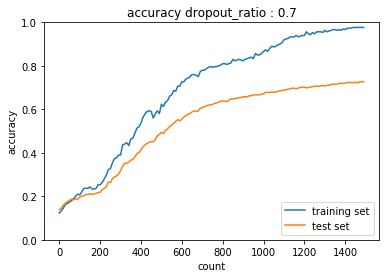

In [121]:
import numpy as np
from collections import OrderedDict
from common import layers
from data.mnist import load_mnist
import matplotlib.pyplot as plt
from multi_layer_net import MultiLayerNet
from common import optimizer

(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True)

print("データ読み込み完了")

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
d_train = d_train[:300]

# ドロップアウト設定 ======================================
use_dropout = True
dropout_ratio_list = [0.15,0.3,0.5,0.7]
# ====================================================
weight_decay_lambda = 0.005
optimizer = optimizer.SGD(learning_rate=0.01)
for drop_ratio in dropout_ratio_list:

    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                            weight_decay_lambda=weight_decay_lambda, use_dropout = use_dropout, dropout_ratio = dropout_ratio)
    
    # optimizer = optimizer.Momentum(learning_rate=0.01, momentum=0.9)
    # optimizer = optimizer.AdaGrad(learning_rate=0.01)
    # optimizer = optimizer.Adam()

    iters_num = 1500
    train_size = x_train.shape[0]
    batch_size = 100

    train_loss_list = []
    accuracies_train = []
    accuracies_test = []

    plot_interval=10


    for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        d_batch = d_train[batch_mask]

        grad = network.gradient(x_batch, d_batch)
        optimizer.update(network.params, grad)

        loss = network.loss(x_batch, d_batch)
        train_loss_list.append(loss)    

        if (i+1) % plot_interval == 0:
            accr_train = network.accuracy(x_train, d_train)
            accr_test = network.accuracy(x_test, d_test)
            accuracies_train.append(accr_train)
            accuracies_test.append(accr_test)

            #print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
            #print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))        

    lists = range(0, iters_num, plot_interval)
    plt.plot(lists, accuracies_train, label="training set")
    plt.plot(lists, accuracies_test,  label="test set")
    plt.legend(loc="lower right")
    plt.title("accuracy dropout_ratio : " + str(drop_ratio))
    plt.xlabel("count")
    plt.ylabel("accuracy")
    plt.ylim(0, 1.0)
    # グラフの表示
    plt.show()

## 実装演習（CNN）

CNNの畳み込み層の計算ではim2col(image to column)が使われる。\
3次元や4次元の入力データを二次元の行列に変換する処理がim2col\
二次元データの1行は、1回のフィルター処理で処理されるデータを並べたものになる。
それをフィルターを適用する順番に要素を増やしていく。

### im2colの実装

In [178]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape #N:sampale数, C:Channel, H;height, W; width
    
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)]) #padding処理
    col = np.zeros((N,C,filter_h,filter_w,out_h,out_w)) 
    
    
    for y in range(filter_h):
        y_max = y + stride * out_w
        for x in range(filter_w):
            x_max = x + stride * out_w
            
            #ここで、一回のフィルター処理が行われる要素を抜き出している。
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    
    #
    col = col.transpose(0, 4, 5, 1, 2, 3) # (N, C, filter_h, filter_w, out_h, out_w) -> (N, filter_w, out_h, out_w, C, filter_h)    
    
    col = col.reshape(N * out_h * out_w, -1)
    print(col)
    return col

## col2imの実装

im2colとは反対に、行列をテンソルの形式に変換する。
逆伝搬で使用される処理

In [179]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_shape
    # 切り捨て除算    
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2) # (N, filter_h, filter_w, out_h, out_w, C)

    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

## 畳み込みクラスの実装

順伝搬でim2col, 逆伝搬でcol2imを使用

In [182]:
class Convolution:
    
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = W
        self.stride = stride
        self.pad = pad
        
        #中間データ(backward時に使用)
        self.x = None
        self.col = None
        self.col_W = None
        
        #フィルターバイアスの勾配
        self.dW = None
        self.db = None
        
        
        
    def forward(self, x):
        
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        
        #出力のサイズを計算
        out_h = int((H + 2 * self.pad - FH)/self.stride) + 1
        out_w = int((W + 2 * self.pad - FW)/self.stride) + 1
        
        
        #入力を行列に変換
        col = im2col(x, FH, FW, self.stride, self.pad)
        
        #フィルターを行列に変換
        col_W = self.W.reshape(FN,-1).T
        
        out = np.dot(col, col_W) + self.b
        
        #形を元に戻す
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        self.x = x
        self.col = col
        self.col_W = col_W
        
        return out
        
        
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
        
        self.db = np.sum(dout, axis = 0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout, self.col_W.T)
        # dcolを画像データに変換
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

## ConvNetお試し
畳み込み-poolng-affine-affineのNNを実装し、MNISTでお試し。

In [184]:
class SimpleConvNet:
    # conv - relu - pool - affine - relu - affine - softmax
    def __init__(self, input_dim=(1, 28, 28), conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']        
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = layers.Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = layers.Relu()
        self.layers['Pool1'] = layers.Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = layers.Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = layers.Relu()
        self.layers['Affine2'] = layers.Affine(self.params['W3'], self.params['b3'])

        self.last_layer = layers.SoftmaxWithLoss()

    def predict(self, x):
        for key in self.layers.keys():
            x = self.layers[key].forward(x)
        return x
        
    def loss(self, x, d):
        y = self.predict(x)
        return self.last_layer.forward(y, d)

    def accuracy(self, x, d, batch_size=100):
        if d.ndim != 1 : d = np.argmax(d, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            td = d[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == td) 
        
        return acc / x.shape[0]

    def gradient(self, x, d):
        # forward
        self.loss(x, d)
        
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grad = {}
        grad['W1'], grad['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grad['W2'], grad['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grad['W3'], grad['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grad

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.5192
                : 10. 正答率(テスト) = 0.505
Generation: 20. 正答率(トレーニング) = 0.5994
                : 20. 正答率(テスト) = 0.591
Generation: 30. 正答率(トレーニング) = 0.7184
                : 30. 正答率(テスト) = 0.69
Generation: 40. 正答率(トレーニング) = 0.79
                : 40. 正答率(テスト) = 0.753
Generation: 50. 正答率(トレーニング) = 0.8238
                : 50. 正答率(テスト) = 0.779
Generation: 60. 正答率(トレーニング) = 0.8504
                : 60. 正答率(テスト) = 0.817
Generation: 70. 正答率(トレーニング) = 0.8612
                : 70. 正答率(テスト) = 0.822
Generation: 80. 正答率(トレーニング) = 0.8838
                : 80. 正答率(テスト) = 0.857
Generation: 90. 正答率(トレーニング) = 0.8906
                : 90. 正答率(テスト) = 0.87
Generation: 100. 正答率(トレーニング) = 0.9
                : 100. 正答率(テスト) = 0.863
Generation: 110. 正答率(トレーニング) = 0.9028
                : 110. 正答率(テスト) = 0.862
Generation: 120. 正答率(トレーニング) = 0.9122
                : 120. 正答率(テスト) = 0.874
Generation: 130. 正答率(トレーニング) = 0.9124
                : 130. 正答率(テスト) = 0.89
Ge

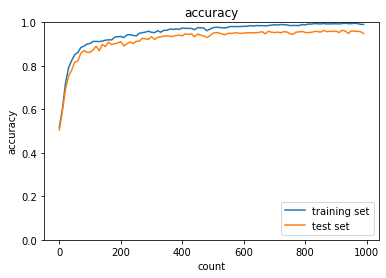

In [185]:
from common import optimizer

# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(flatten=False)

print("データ読み込み完了")

# 処理に時間のかかる場合はデータを削減 
x_train, d_train = x_train[:5000], d_train[:5000]
x_test, d_test = x_test[:1000], d_test[:1000]


network = SimpleConvNet(input_dim=(1,28,28), conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

optimizer = optimizer.Adam()

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10



for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]
    
    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

## AlexNet実装（TensorFlow使用）
モデル構築まで

In [191]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers

In [235]:
model = models.Sequential()

In [236]:
#第1層
model.add(layers.Conv2D(96, 11, strides=4 ,padding = "same",input_shape=(224,224,3)))
model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2,2)))
model.add(layers.Conv2D(256, 5))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
model.add(layers.Conv2D(384, 3))
model.add(layers.Conv2D(384, 3)) 
model.add(layers.Conv2D(256, 3)) 
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(4096))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(4096))
model.add(layers.Dropout(0.5))

In [237]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 56, 56, 96)        34944     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 23, 23, 256)       614656    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 9, 9, 384)         885120    
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 7, 7, 384)         1327488   
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 5, 5, 256)       